# New Automatic Wavelength Calibration Method

## Overview
The current method implemented, although it produces results, they are not good enough for science. The following plots were sent to me by Alba Aller. The tests correspond to a _Radial Velocity Standard_ HD177409 observed with the 1200M2  instrument configuration using the slit of 1.03 arcseconds.
![Radial Velocity](img/RVstd_goodman_beta1.png)
In this plot the points should be on the dashed line.
![Flux](img/RVstd_flux_TwoLines_ThreeNights.png)



## Requirements - General Description

An automatic wavelength calibration function should be able to take as an argument a file name or a `CCDData` instance and be able to:
- Decide wether to use it to find a wavelength Solution or needs a comparison lamp if not provided.
  - `COMP` or `OBJECT`
- If it is an `OBJECT` it has to:
  - Identify a matching comparison lamp and use it to find the wavelength solution
  - Be able to get the solution from more than one comparison lamp AND combine them.
- Identify Emission Lines
- Isolate each line in order to identify the exact location of the line
- Find the line location with high accuracy.
- Identify matching Angstrom values
- Validate match
- Produce a mathematical model representation for the wavelength solution
- Produce a representation fo the wavelength solution for a FITS header.


## Requierements - Not to be implemented

- Read or write files, should use `goodman.pipeline.core.read_fits` and `goodman.pipeline.core.write_fits`
- Graphics

# Prototype function

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


/user/simon/data/soar/work/aller/2017-06-11/RED/gcfzsto_0131_CuHeAr_G1200M2_slit103_1.fits
is abs path
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Input is a comparison Lamp COMP
identifying liines in lamp  gcfzsto_0131_CuHeAr_G1200M2_slit103_1.fits
[  43  126  573  853  889 1099 1957 2000 2287 2342 2525 2654 2890 3140 3212
 3264 3361 3487 3829 3848 3951 4010 4040]


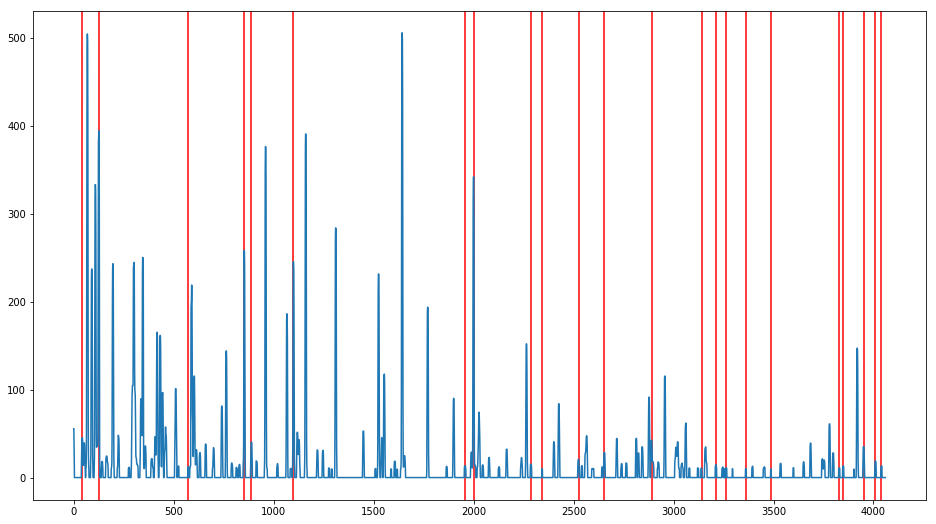

gcfzsto_0144_Abell36_G1200M2_slit103.fits
file exist
INFO

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
OBJECT
No lamps provided
save non-calibrated object
Call wavelength calibration finder...


In [128]:
from ccdproc import (CCDData, ImageFileCollection)
from scipy import (signal, interpolate)
import os
import sys
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits.header import Header

import sys
sys.path.append('/user/simon/development/soar/goodman')

# import goodman
from pipeline.core import (read_fits, write_fits)

plt.rcParams["figure.figsize"] = [16,9]

class DataValidationError(Exception):
        
    def __init__(self, message):
        Exception.__init__(self, message)
     
    
    


def validate_input(ccd_data):
    assert isinstance(ccd_data, str) or isinstance(ccd_data, CCDData)

    if isinstance(ccd_data,  CCDData):
        ccd = ccd_data.copy()
    elif not isinstance(ccd_data, CCDData):
        ccd = read_fits(ccd_data)        
    else:
        raise NotImplementedError("Can't process {:s}".format(str(type(ccd_data))))
    
    if not isinstance(ccd, CCDData):
        raise DataValidationError('Invalid Input: Data is not an instance of CCDData.')
    elif  ccd.header['NAXIS'] != 1:
        raise DataValidationError("Wrong data dimensions")
        
    return ccd
#     except FileNotFoundError:
#         raise DataValidationError('FileNotFoundError: File not found')
#     except AssertionError:
#         raise DataValidationError("AssertionError: Data has to be 1D")
        
    
   
    
path = '/user/simon/data/soar/work/aller/2017-06-11/RED'
file_1 = 'gcfzsto_0131_CuHeAr_G1200M2_slit103_1.fits'
file_2 = 'cfzsto_0131_CuHeAr_G1200M2_slit103.fits'
file_3 = 'gcfzsto_0144_Abell36_G1200M2_slit103.fits'

lamps_list = ['gcfzsto_0131_CuHeAr_G1200M2_slit103_1.fits',
              'gcfzsto_0170_CuHeAr_G1200M2_slit103.fits',
              'gcfzsto_0174_CuHeAr_G1200M2_slit103.fits']

lamps = [os.path.join(path, lamp_file) for lamp_file in lamps_list]


# for file in [file_1, file_2, file_3]:
#     full_path = os.path.join(path, file)

#     # ccd = CCDData.read(full_path, unit=u.adu)
#     print(" ")
#     print(full_path)
#     wavelength_solution(ccd_data=full_path, lamps=lamps)
    

#     # wavelength_solution(ccd_data=ccd)



def identify_lines(lamp):
    print("identifying liines in lamp ", lamp.header['GSP_FNAM'])
    
    filtered_data = np.where(np.abs(lamp.data > lamp.data.min() + 0.01 * lamp.data.max()),
                             lamp.data,
                             np.zeros(lamp.data.shape))
    
    peaks = signal.argrelmax(filtered_data, axis=0, order=7)[0]
    print(peaks)
    
    for peak in peaks:
        plt.axvline(peak, color='r')
    plt.plot(filtered_data)
    plt.show()

def get_wavelength_solution(comp_lamps):
    assert isinstance(comp_lamps, list)
    assert all([isinstance(lamp, CCDData) for lamp in comp_lamps])
    
    for lamp in comp_lamps:
        lamp_lines = identify_lines(lamp=lamp)


class WavelengthCalibration(object):
    
    def __init__(self, data_path=None):
        assert os.path.isdir(data_path)
        self.path = data_path
        self.image_collection = ImageFileCollection(self.path)
        self.comparison_lamps = None
        
    def __call__(self, file_name, lamps=None):
        print(file_name)
        if os.path.isabs(file_name) and os.path.isfile(file_name):
            print("is abs path")
            self.wavelength_solution(ccd_data=file_name, lamps=lamps)
        elif os.path.isfile(os.path.join(self.path, file_name)):
            print("file exist")
            full_path = os.path.join(self.path, file_name)
            self.wavelength_solution(ccd_data=full_path, lamps=lamps)
        else:
            print("Can't locate file: {:s}".format(os.path.join(self.path,
                                                                file_name)))
            
    def wavelength_solution(self, ccd_data, lamps=None):
    
        assert lamps is None or isinstance(lamps, list)
        lamps_list = None
    
        try:
            ccd = validate_input(ccd_data=ccd_data)
            if lamps is not None:
                lamps_list = []
                for lamp in lamps:
                    print(lamp)
                    ccd_lamp = validate_input(ccd_data=lamp)
                    lamps_list.append(ccd_lamp)
        except DataValidationError as error:
            print("DataValidationError:", error)
            return
        
    
        if ccd.header['OBSTYPE'] == 'OBJECT':
            print('OBJECT')
            if lamps_list is not None:
                print("Lamp is a list or CCData or a filename")
                get_wavelength_solution(comp_lamps=lamps_list)
            else:
                print("No lamps provided")
                print("save non-calibrated object")
            
                # lamps_list = self.get_comparison_lamp(data=ccd)
            
           
                
            print("Call wavelength calibration finder...")
            
        elif ccd.header['OBSTYPE'] == 'COMP':
            print('Input is a comparison Lamp COMP')
            get_wavelength_solution(comp_lamps=[ccd])
#             if lamps_list is not None:
#                 print("Warning: lamps will be treated as independent")
#                 for ccd_lamp in lamps_list:
#                     plt.plot(ccd_lamp.data)
#                     plt.title("Lamp: {:s}".format(ccd_lamp.header['GSP_FNAM']))
#                     plt.show()
#             print("Call wavelength calibration finder...")
        else:
            print(ccd.header['OBSTYPE'])
    
#         print(ccd.data.shape)
#         plt.title(os.path.basename(ccd_data))
#         plt.plot(ccd.data)
#         plt.show()
        
#     def get_comparison_lamp(self, data):
#         assert isinstance(data, CCDData)        
        
#         image_collection = self.image_collection.summary.to_pandas()
#         self.comparison_lamps = image_collection[(image_collection.naxis == 1) &
#                                                  (image_collection.obstype == 'COMP') &
#                                                  (image_collection.grating == data.header['GRATING']) &
#                                                  (image_collection.grt_targ == data.header['GRT_TARG']) &
#                                                  (image_collection.cam_targ == data.header['CAM_TARG'])] 
#         print(self.comparison_lamps)
    
    
            
            
        
        

wavelength_calibration = WavelengthCalibration(data_path=path)
full_path = os.path.join(path, file_1)
wavelength_calibration(full_path)
wavelength_calibration(file_3)
    
    